In [1]:
%run init_notebook.py

In [ ]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [ ]:
def min_max_scale(x):
    return (x - x.min())/(x.max() - x.min())

In [ ]:
import scipy

In [ ]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson


from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col


In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

from src.utils import get_statsmodels_tab

In [ ]:
from src.utils import get_stars

In [9]:
def get_statsmodels_var_summary(var, col_name: int = 1, **kwargs):
    summary = pd.DataFrame(var.pvalues.stack(), columns=['pval'])
    summary['coef'] = np.concatenate([np.ones(var.neqs), var.coefs.ravel()])
    summary['stder'] = var.stderr.unstack().values
    summary['stars'] = summary.pval.map(get_stars)
    
    lst_txt = []
    for i, row in summary.round(3).iterrows():
        lst_txt.append( f"{row['coef']}{row['stars']}\n[{row['stder']}]" )
    summary['txt'] = lst_txt
    
    columns = [(col_name, i) for i in summary.columns]
    summary.columns = pd.MultiIndex.from_tuples(columns)
    
    return summary

def get_statmodels_var_summary_joint(lst_of_vars, lst_of_names = None, **kwargs):
    if lst_of_names is None:
        lst_of_names = [*range(len(lst_of_vars))]
    lst_summaries = [get_statsmodels_var_summary(var, col_name=lst_of_names[i]) for i, var in enumerate(lst_of_vars)]
    df = lst_summaries[0]
    for i, summary in enumerate(lst_summaries[1:]):
        df = df.join(summary, how='outer')
    
    
    return df

# load data

In [9]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)

topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [10]:
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'delta_pe_MY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war',
        'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_perc95_MY', 'pi_perc05_MY', 'pi_perc05_WY', 'pi_perc95_WY',
        'pi_exp_MY', 'i_exp_MY', 'pi_exp_WY', 'riskaversion'
    ]].drop_duplicates().copy()
df = pd_join_dfs([df, hhp.set_index('date_forecast')[
    ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY']
].drop_duplicates().add_suffix("_F"),],
                 index_name='date_recorded')

In [11]:
df['pi_exp_uncertainty_WY_F'] = df['pi_exp975_WY_F'] - df['pi_exp025_WY_F']
df['pi_perc_uncertainty_WY'] = df['pi_perc95_WY'] - df['pi_perc05_WY']

df['pi_exp_uncertainty_MY_F'] = df['pi_exp975_MY_F'] - df['pi_exp025_MY_F']
df['pi_perc_uncertainty_MY'] = df['pi_perc95_MY'] - df['pi_perc05_MY']

In [12]:
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y']], 'M', True)

df['week_recorded'] = df.index.to_period('W').to_timestamp()
df['week_forecast'] = df.date_forecast.dt.to_period('W').dt.to_timestamp()
df['month_recorded'] = df.date_recorded.dt.to_period('M').dt.to_timestamp()
df = df.reset_index(drop=True)

In [13]:
# check

In [14]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    49546.000000
mean         1.937573
std          1.801603
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

# plot data

In [15]:
sub = pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'pi_exp_MY', 'pi_perc95_MY', 'pi_perc05_MY'],
           "M", 'last').dropna()
sub2 = pd_groupby(df.set_index('date_forecast'), 
                  ['pi_de_Y', 'pi_exp975_MY_F', 'pi_exp025_MY_F', 'pi_de_estimate_Y', 'pi_exp_MY_F'], 'M', 'last').dropna()

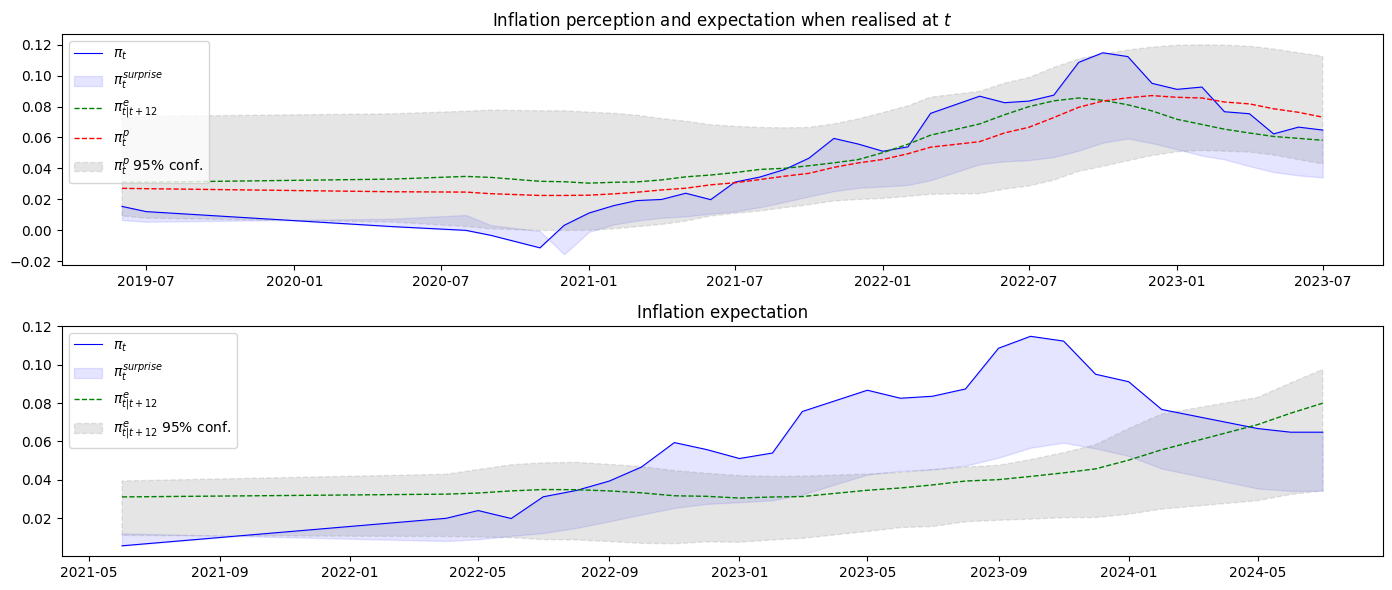

In [16]:
fig, ax = plt.subplots(2,1, figsize=(14,6))

ax[0].plot(sub['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[0].fill_between(sub.index, sub['pi_de_estimate_Y'], sub['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)

ax[0].plot(sub['pi_exp_MY'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[0].plot(sub['pi_perc_MY'], linestyle='dashed', color='red', lw=1, label=r'$\pi^p_{t}$')
ax[0].fill_between(sub.index, sub['pi_perc95_MY'], sub['pi_perc05_MY'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^p_{t}$ 95% conf.')

ax[0].set_title('Inflation perception and expectation when realised at $t$', size=12)
ax[0].legend(loc='upper left', )

ax[1].plot(sub2['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[1].fill_between(sub2.index, sub2['pi_de_estimate_Y'], sub2['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
ax[1].plot(sub2['pi_exp_MY_F'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[1].fill_between(sub2.index, sub2['pi_exp975_MY_F'], sub2['pi_exp025_MY_F'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^e_{t|t+12}$ 95% conf.')
ax[1].set_title("Inflation expectation", size=12)
ax[1].legend()

fig.tight_layout()

save_fig(fig, 'plot_inflation.png')

# Expectation and perception

In [17]:
# get pi percption error
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=6)
df = get_individual_perc_error(df, 'delta_pe_MY', pi[['pi_de_Y_diff']], ind_cols=['date_forecast', 'id'], count_thresh=5)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=5)

In [18]:
lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i])
lst_error_cols

['delta_pe_MY_error_act', 'pi_exp_MY_error_act', 'pi_perc_MY_error_act']

## Perception error: What explains the perception error in the cross-section

In [19]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

delta_pe_MY_error_act (10748, 2)
pi_exp_MY_error_act (10976, 2)
pi_perc_MY_error_act (9130, 2)


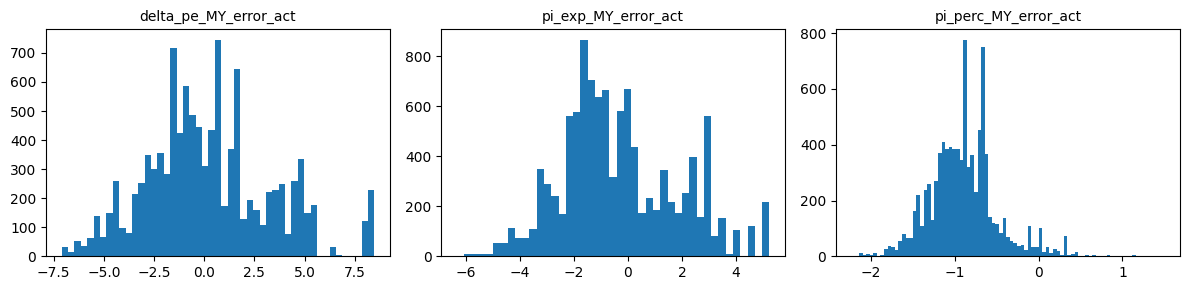

In [21]:
fig, axes = plt.subplots(1,3,)
for i, ax in enumerate(axes.ravel()):
    ax.set_title(lst_error_cols[i], size=10)
    ax.hist(df[['id', lst_error_cols[i]]].drop_duplicates().drop('id', axis=1).dropna(), bins='fd')

fig.tight_layout();
save_fig(fig, 'emp_error_hist.png')

In [22]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
ols_data = hhp[
    [
        'is_food_shop',  
        'pinc_midpoint', 
        'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'wealth_bank_midpoint', 
        # 'savings_planned', 
        # 'profession_txt',
        # 'ecbtrust',
        # 'pr
        # 'hhsize',
        'riskaversion',
        'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
ols_data = ols_data.join(_).reset_index().groupby('id').last()
ols_data2 = ols_data.copy()

In [23]:
DICT_PARSE_COLS.update(
    {
        'hhsize': 'categoryO', 'hhinc_midpoint': 'categoryO', 'pinc_midpoint': 'categoryO', 'profession_txt': 'category',
        'riskaversion': 'categoryO'
    }
)
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
ols_data = pd_df_astype(ols_data, DICT_PARSE_COLS)

In [24]:
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col], dtype=bool)
        dummies = dummies.add_prefix(col)
        ols_data = ols_data.join(dummies.iloc[:, :])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [25]:
# multiple ols models
lst_ols_mods = []
for col in lst_error_cols:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    d = d.dropna()
    print(d.shape)
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    lst_ols_mods.append(ols)

(3282, 42)
(3397, 42)
(2568, 42)


In [26]:
summary_col(lst_ols_mods, stars=True)

,delta_pe_MY_error_act,pi_exp_MY_error_act,pi_perc_MY_error_act
is_food_shop,-0.1517,0.0313,0.1145***
,(0.2063),(0.1395),(0.0415)
pinc_midpoint250.0,0.0355,0.0163,0.0432
,(0.6130),(0.4290),(0.1234)
pinc_midpoint750.0,-0.0531,0.1456,-0.0009
,(0.5946),(0.4166),(0.1184)
pinc_midpoint1250.0,-0.0927,0.1685,0.1314
,(0.5806),(0.4068),(0.1156)
pinc_midpoint1750.0,-0.3325,-0.0739,0.0540
,(0.5798),(0.4066),(0.1154)


In [27]:
x = get_statsmodels_tab(lst_ols_mods, join_on=" ")

_ = list(x[0][(x[0].swaplevel(axis=1)['P>|t|'].astype(float) <= 0.1).sum(axis=1) > 0].index)
_ = x[3].loc[_ + list(x[3].iloc[-3:].index)]
save_pd_df(_, 'tab_cross_section_error.csv', GRAPHS_DIR)

## risk aversion delta_pe

In [29]:
from src.utils import get_stars

In [32]:
sub2 = get_statsmodels_summary(lst_ols_mods, ['conf_upper', 'conf_lower', 'coef']).copy()
sub2 = sub2.swaplevel(axis=1)['delta_pe_MY_error_act'].loc[[i for i in sub2.index if 'risk' in i]]

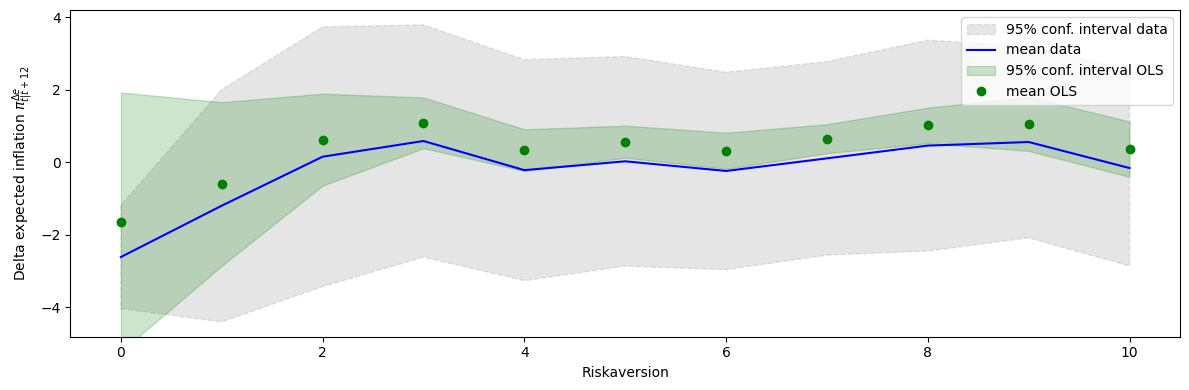

In [34]:
sub = ols_data2.loc[~ols_data2.riskaversion.isna()].copy()
sub = sub[['delta_pe_MY_error_act', 'riskaversion']].dropna()
sub = sub.groupby('riskaversion', observed=True).aggregate(['mean', 'std']).droplevel(0, axis=1)

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.fill_between(sub.index, sub['mean'] - 1.2 *  sub['std'], sub['mean'] + 1.2 *  sub['std'], alpha=.2, color='grey', 
                 label='95% conf. interval data', linestyle='dashed')
ax.plot(sub['mean'], color='blue', label='mean data')
y_lim = ax.get_ylim()

ax.fill_between(sub.index, sub2['conf_lower'], sub2['conf_upper'], color='green', alpha=.2, label='95% conf. interval OLS')
ax.plot(sub2['coef'].values, lw=0, marker='o', color='green', label='mean OLS')

ax.set_ylim(y_lim)

ax.legend()
ax.set_xlabel("Riskaversion")
ax.set_ylabel("Delta expected inflation $\pi^{\Delta e}_{t|t+12}$")

fig.tight_layout()
save_fig(fig, "riskaversion.png")

## Test errors in time series dimension

In [35]:
for col in [('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act')]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [36]:
arr = df.set_index('date_recorded').delta_pe_MY_error_act_WY.drop_duplicates().values 
arr = df.set_index('date_recorded').pi_perc_MY_all_error_act_WY.drop_duplicates().values 

In [37]:
arr = np.random.randn(100) / 100
arr1 = np.random.randn(100) / 100

In [38]:
# cross_corr(arr, arr1, lags=10);

In [39]:
join_on = '\n'
# lst_models = [vecm, vecm2]
def get_statsmodels_tab_vecm(lst_models, join_on: str = '\n', id_var: int = 0):
    assert id_var <= len(lst_models[0].names)-1, "id exceeds model len"
    
    lst_dfs = [pd.DataFrame(mod.summary().tables[id_var].data) for mod in lst_models]

    for i, df in enumerate(lst_dfs):
        df.columns = df.iloc[0]
        df = df.iloc[1:].copy()
        df['stars'] = df['P>|z|'].apply(lambda x: get_stars(float(x)))
        df['print'] = df.apply(lambda x: f"{float(x['coef'])}{x['stars']}{join_on}[{float(x['std err'])}]" , axis=1)
        lst_dfs[i] = df

        # df.

    cols = [[(lst_models[idx].names[0], i) for i in df.columns] for idx, df in enumerate(lst_dfs)]
    cols = [pd.MultiIndex.from_tuples(col) for col in cols]

    for i, df in enumerate(lst_dfs):
        # df.iloc[0, 0] = 'vars'
        df.columns = cols[i]
        lst_dfs[i] = df
    
    lst_dfs = [df.set_index(df.iloc[:,0]).iloc[:,1:] for df in lst_dfs]
    df = lst_dfs[0]
    for d in lst_dfs[1:]:
        df = df.join(d)
    out = df.copy()
    # out = pd.concat(lst_dfs , join='outer', axis=1)
    # out.index = out.iloc[:,0]
    # out = out.loc[:, ~(out.iloc[0] == 'vars')] 

    out1 = out.swaplevel(axis=1)['print']
    out1.loc['N'] = [mod.nobs for mod in lst_models]
    out1.loc['Coint rank'] = [mod.coint_rank for mod in lst_models]
    
    return out, out1

### pi perc

In [40]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()

In [41]:
cols_endog, cols_exog = ['pi_perc_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var1 = VAR(sub[cols_endog + cols_exog].diff().dropna()).fit(maxlags=2)
# print(var1.summary())

In [42]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.018553484289268035
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
6 6


In [43]:
# vecm1.irf(periods=5).plot()
# plt.tight_layout()
# ;

### pi perc error

In [44]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY_error_act',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [45]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var2 = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2, ic='fpe')
# print(var1.summary())

In [46]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 7) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

pi_perc_MY_error_act ADF p-val: 4.59317633173586e-08
pi_de_surprise_Y ADF p-val: 0.2695181207003059
pi_de_estimate_Y ADF p-val: 0.7897732982121397
3
6 1


In [47]:
# vecm2.irf().plot()
# plt.tight_layout();

In [48]:
lst_vecms = [vecm1, vecm2]

In [49]:
vecm = lst_vecms[0]

In [115]:
from statsmodels.regression.linear_model import RegressionResultsWrapper
from statsmodels.tsa.vector_ar.vecm import VECMResults

def _get_statsmodels_ols_summary(mod):
    df = pd.DataFrame(pd.concat([mod.params, mod.pvalues, mod.tvalues], axis=1))
    df.columns = ['coef', 'pval', 'stat']
    
    df_conf = mod.conf_int()
    df_conf.columns = ['conf_lower', 'conf_upper']
    
    endog_name = mod.model.endog_names
    df = df.join(df_conf)
    return df, endog_name

def _get_statmodels_vecm_summary(mod, endog_index: 0):
    endog_name = vecm.model.endog_names[endog_index]
    
    df = pd.DataFrame(vecm.summary().tables[0].data).iloc[1:].set_index(0)
    df.index.name = ''
    df.columns = ['coef', 'stderr', 'stat', 'pval', 'conf_lower', 'conf_upper']
    df = df.astype(float)
    
    return df[['coef', 'pval', 'stat', 'conf_lower', 'conf_upper']], endog_name
    

def get_statsmodels_summary(lst_mods, col_out: str = 'print', vecm_endog_index: int = 0, seperator: str = "\n"):
    lst_dfs = []
    endog_name_save = ""
    for idx, mod in enumerate(lst_mods):
        
        if type(mod) == RegressionResultsWrapper:
            df, endog_name = _get_statsmodels_ols_summary(mod)
            
        elif type(mod) == VECMResults:
            df, endog_name = _get_statmodels_vecm_summary(mod, vecm_endog_index)
            
        else:
            raise KeyError(f"{type(mod)} not specified")
            
        if endog_name == endog_name_save:
                endog_name += f"_{idx}"
        endog_name_save = endog_name
    
        # layout
        df['star'] = df['pval'].apply(lambda x: get_stars(x))
        df['print'] = df.coef.round(3).astype(str) + " " + df.star.astype(str) + seperator + "[" + df.stat.round(3).astype(str) + "]"
        
        cols = [list(df.columns), list([endog_name] * df.shape[1])]
        df.columns = pd.MultiIndex.from_tuples(list(map(tuple, zip(*cols))))

        lst_dfs.append(df)

        out = pd.concat([df[col_out] for df in lst_dfs], axis=1, join='outer')

    return out

In [117]:
get_statsmodels_summary(lst_vecms)

,pi_perc_MY,pi_perc_MY_1
,,
L1.pi_perc_MY,0.267 \n[1.429],0.267 \n[1.429]
L1.pi_de_surprise_Y,0.179 *\n[1.932],0.179 *\n[1.932]
L1.pi_de_estimate_Y,0.486 ***\n[4.52],0.486 ***\n[4.52]
L2.pi_perc_MY,0.319 \n[1.496],0.319 \n[1.496]
L2.pi_de_surprise_Y,0.067 \n[0.694],0.067 \n[0.694]
L2.pi_de_estimate_Y,0.068 \n[0.537],0.068 \n[0.537]
L3.pi_perc_MY,-0.048 \n[-0.258],-0.048 \n[-0.258]
L3.pi_de_surprise_Y,-0.037 \n[-0.452],-0.037 \n[-0.452]
L3.pi_de_estimate_Y,0.416 ***\n[3.329],0.416 ***\n[3.329]


### delta exp

In [118]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [119]:
cols_endog, cols_exog = ['delta_pe_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit()
# vecm3.summary()

delta_pe_MY ADF p-val: 0.44313200381795326
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
6 6


In [120]:
# vecm3.irf().plot()
# plt.tight_layout();

### delta exp error

In [121]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY_error_act_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [122]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm4.summary()

delta_pe_MY_error_act_MY ADF p-val: 0.9509824412702439
pi_de_surprise_Y ADF p-val: 0.0535354526734725
pi_de_estimate_Y ADF p-val: 0.8029480317761679
2
5 1


## uncertainty

In [135]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_uncertainty_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [136]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm5.summary()

pi_perc_uncertainty_MY ADF p-val: 0.0006861008216353449
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
1
5 1


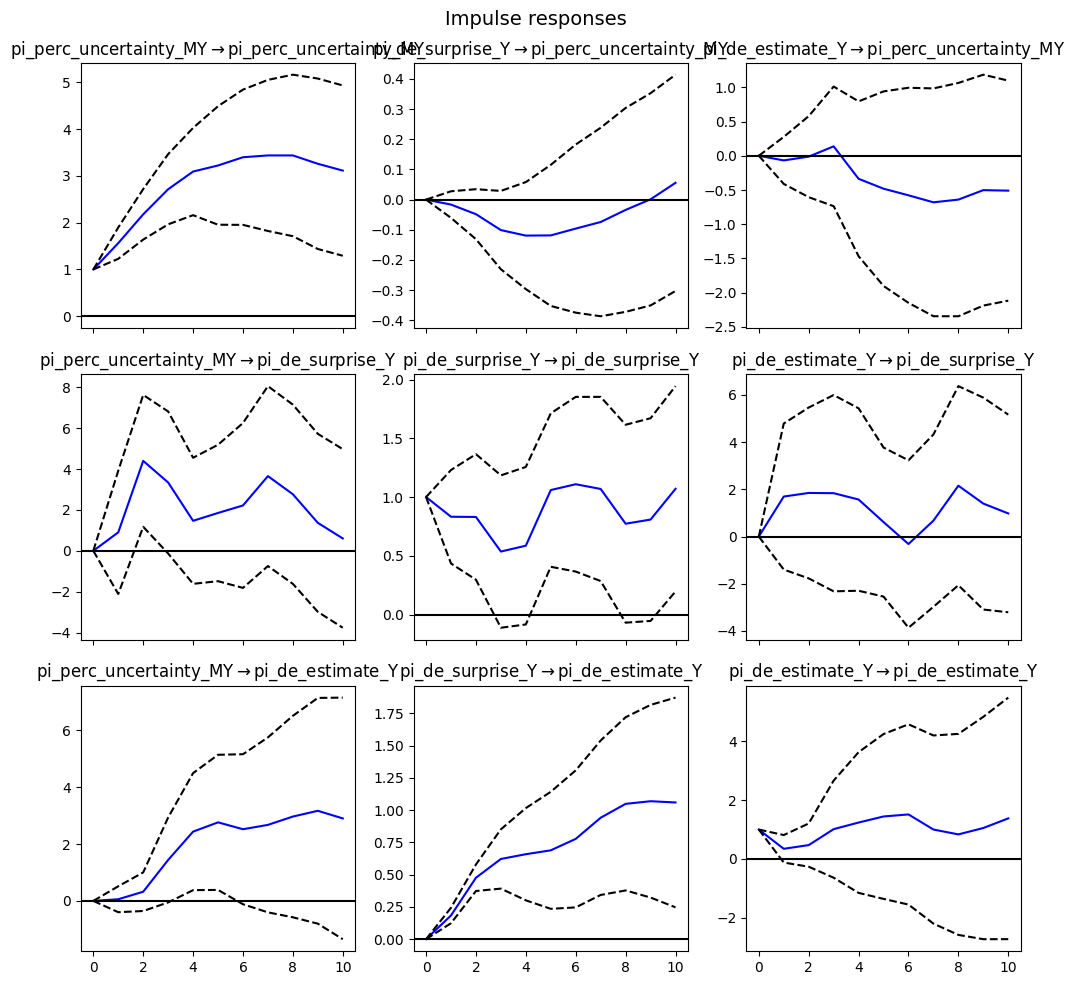

In [137]:
vecm5.irf().plot()
plt.tight_layout();

## summary

In [124]:
_, x = get_statsmodels_tab_vecm([vecm1, vecm2, vecm3, vecm4], id_var=0)
save_pd_df(x, 'tab_vecm_resid.csv', GRAPHS_DIR)

In [125]:
def get_fig_subplots(n_plots: int, n_cols: int = 2, figsize: tuple =(6,3.5), **kwargs):
    n_rows = int(np.ceil(n_plots/n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(figsize[0] * n_rows, figsize[1] * n_cols), **kwargs)
    if n_plots == 1 and n_cols == 1:
        return fig, ax 
    else:
        ax = ax.ravel()[:n_plots]
    return fig, ax
    
lst_vecms = [vecm1, vecm2, vecm3, vecm4]

def get_multiple_vecm_irfs(lst_vecms, idx_vecm: tuple = (0,1), dict_titles: dict = None, **kwargs):
    fig, axes = get_fig_subplots(len(lst_vecms), **kwargs)
    for idx, ax in enumerate(axes):
        irf = lst_vecms[idx].irf()
        
        ax.plot(irf.irfs[:, *idx_vecm], color='blue', label='irf')
        ax.fill_between(range(len(irf.irfs)), 
                        irf.irfs[:, idx_vecm[0], idx_vecm[1]] + 1.96 * irf.stderr()[:, idx_vecm[0], idx_vecm[1]],
                        irf.irfs[:, idx_vecm[0], idx_vecm[1]] - 1.96 * irf.stderr()[:, idx_vecm[0], idx_vecm[1]],
                        alpha=.3, color='grey', linestyle='dashed', label='90% conf.')

        ax.plot(list([0] * irf.irfs.shape[0]), color='black')
        
        n1, n2 = lst_vecms[idx].names[idx_vecm[1]], lst_vecms[idx].names[idx_vecm[0]]
        # print(v.names)
        if dict_titles is not None:
            try:
                n1 = dict_titles[n1]
                n2 = dict_titles[n2]
            except Exception as e:
                n1, n2 = lst_vecms[idx].names[idx_vecm[1]], lst_vecms[idx].names[idx_vecm[0]]
            
        ax.set_title(f"{n1} -> {n2}",)
        ax.legend()
    
    fig.tight_layout()
    return fig

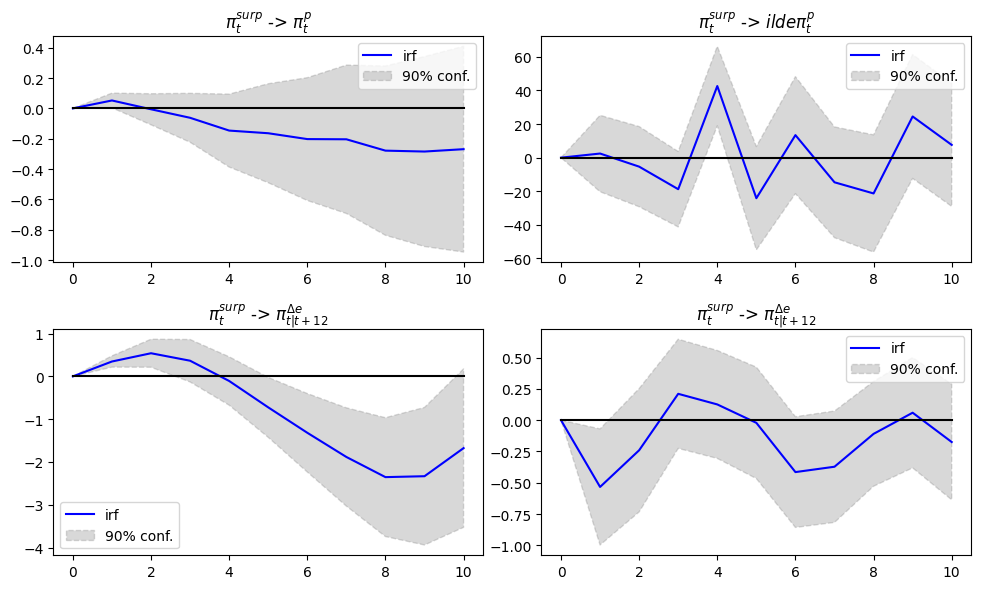

In [126]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "delta_pe_MY_error_act_MY": '$\pi^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\tilde{\pi}^p_{t}$",},
                            figsize=(5,3));
save_fig(fig, "emp_erro_vecm.png")

# News analysis

## overview on news and narratives

In [197]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy() #.iloc[:300]

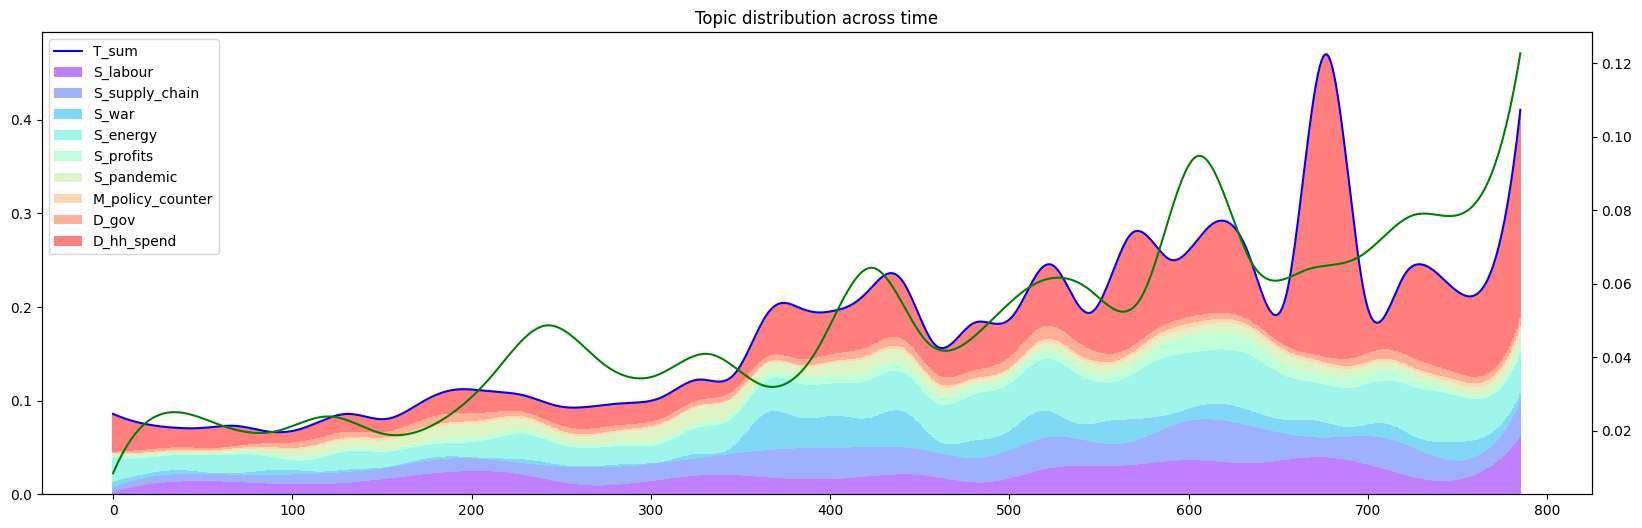

In [198]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1), )

ax.plot(sub.T_sum.values, color='blue', label='T_sum')
ax.twinx().plot(sub.D_inflation.values, color='green', label='D_inflation')
ax.set_title("Topic distribution across time")
ax.legend(loc="upper left");
save_fig(fig, "topics_time.png")

In [268]:
# fig, ax = plt_stacked_bar(
#     sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).apply(lambda x: x / x.sum(), axis=1)
# )
# ax.legend()
# ;

## PCA

In [230]:
X = topics_raw.drop(['D_inflation'], axis=1).diff().copy().dropna()
X = topics.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).diff().copy().dropna()

scaler = StandardScaler().fit(X)
X_std = pd.DataFrame(scaler.transform(X), X.index, X.columns)
pca = PCA(n_components=5).fit(X_std)

NameError: name 'StandardScaler' is not defined

In [ ]:
fig, ax = plt_stacked_bar(pd.DataFrame(pca.components_, columns = X.columns))
ax.legend(X.columns)

In [ ]:
fig, ax = plt.subplots()

ax.plot(X.index, (pca.components_ @ X_std.T).T.sum(axis=1), label='agg pca');
ax2 = ax.twinx()
ax2.plot(topics.T_sum_diff_lag.dropna(), color='red', label='T_sum_diff')
ax.legend()
ax2.legend(loc='upper right')
plt.title('Components across time')

In [ ]:
topics = topics.join(pd.Series((pca.components_ @ X_std.T).T.sum(axis=1), index=X.index, name='T_pca_sum_diff'))
topics['T_pca_sum'] = topics.T_pca_sum_diff.cumsum()

In [ ]:
df = pd_join_freq(
    df.set_index('date_recorded'), 
    topics[['T_pca_sum_diff', 'T_pca_sum']].apply(lambda x: (x - x.min())/(x.max() - x.min())).copy(),
    'W', True)

df = df.reset_index(drop=True)

## war and inflation as given by hh concern

In [269]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']

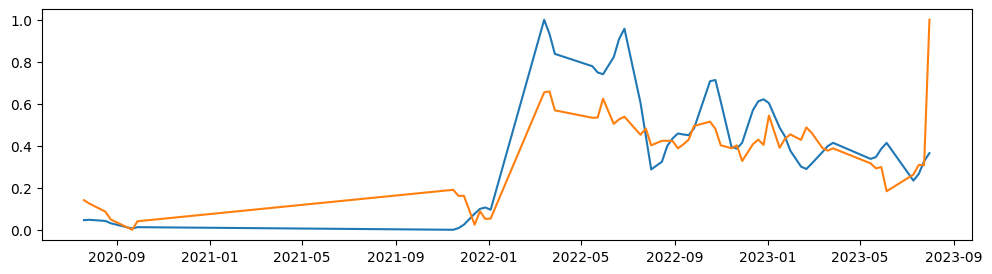

In [270]:
plt.plot(sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x)))
sub[cols_endog + cols_exog] = sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x))

In [222]:
var = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2)
print(var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Mar, 2024
Time:                     15:15:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.46404
Nobs:                     56.0000    HQIC:                  -7.68549
Log likelihood:           70.1987    FPE:                0.000399717
AIC:                     -7.82571    Det(Omega_mle):     0.000336875
--------------------------------------------------------------------
Results for equation S_war
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.006040         0.020788            0.291           0.771
L1.S_war                0.130153         0.199316            0.653           0.514
L1.percprob_war        -0.141955         0.296111   

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Macro analysis

## VECM: Does surprise inflation elicit higher news-paper reporting?

In [328]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'delta_pe_MY_error_act_MY', 
                  'pi_perc_MY_error_act', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
# sub.plot();
sub.shape

(34, 8)

In [329]:
cols_endog, cols_exog = ['pi_perc_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
3
2 0


In [330]:
# vecm1.irf().plot()
# plt.tight_layout();

In [331]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_MY_error_act ADF p-val: 7.217927277626793e-08
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
4
2 0


In [332]:
cols_endog, cols_exog = ['delta_pe_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY',]

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY ADF p-val: 0.5619457365131322
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_perc_MY ADF p-val: 0.01874377846322591
3
2 0


In [333]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY_error_act_MY ADF p-val: 0.020658890361074964
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
2
2 0


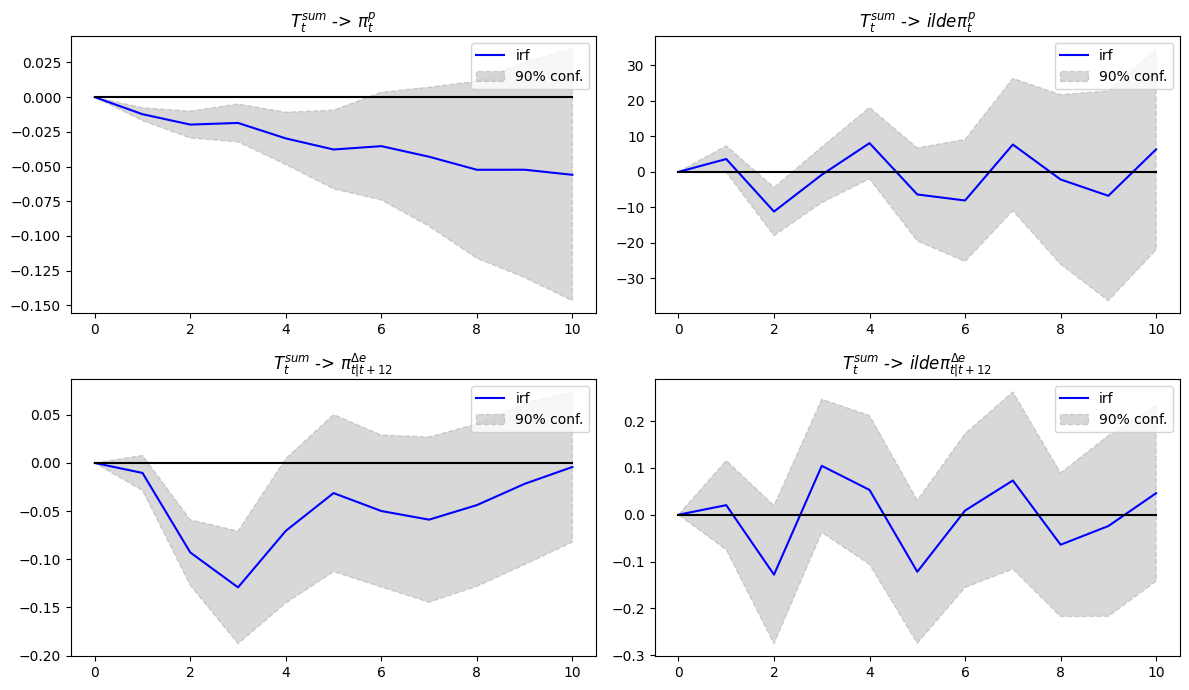

In [334]:
fig = get_multiple_vecm_irfs([vecm1, vecm2, vecm3, vecm4],
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\tilde{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\tilde{\pi}^p_{t}$",
                                         });
save_fig(fig, "emp_vecm_error_news.png")

## uncertainty

In [135]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_uncertainty_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [136]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm5.summary()

pi_perc_uncertainty_MY ADF p-val: 0.0006861008216353449
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
1
5 1


In [335]:
_, tab = get_statsmodels_tab_vecm([vecm1, vecm2, vecm3, vecm4])
save_pd_df(tab, "emp_vecm_error_news.csv", file_path=GRAPHS_DIR)

### without inflation

In [337]:
sub = df.groupby('week_recorded')[['pi_exp_WY', 'delta_pe_WY', 'pi_perc_MY_all_error_act_WY', 'pi_perc_WY', 'T_sum']].last().dropna()
sub.shape

(92, 5)

In [338]:
cols_endog, cols_exog = ['pi_perc_MY_all_error_act_WY'], ['T_sum', 'pi_perc_WY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=1).fit()
# vecm.summary()

pi_perc_MY_all_error_act_WY ADF p-val: 0.008850661014417172
T_sum ADF p-val: 0.9278081776736748
pi_perc_WY ADF p-val: 0.014219717000384888
2
3 2


In [339]:
# irf = vecm.irf()
# irf.plot(figsize=(15,10))
# plt.tight_layout()

## VAR: Does surprise inflation elicit higher news-paper reporting?

In [318]:
from statsmodels.tsa.vector_ar.svar_model import SVAR

Same analysis as Dräger (2015) as VAR to analyse:
$$ \hat{X}_t = \Gamma \hat{X}_{t-1} + u_t $$ 
where
$$X_t = (\hat{\pi}_t, \hat{\pi}^p_t, \hat{\pi}^e_{t-12}, \hat{N}_t), \quad \mbox{where} \quad \hat{z}_t = z_t - z_{t-1} $$

In [322]:
sub = pd_groupby(df.set_index('date_recorded'), [ 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub_d = sub.diff().dropna().copy()

In [391]:
A, B = np.eye(sub.shape[1], dtype=object), np.eye(sub.shape[1], dtype=object)
A[np.tril_indices(A.shape[1], k=-1)] = list(["E"] * A.shape[1] * 2)
# A[-1] = list(["E"] * (A.shape[1]-1)) + [1]
# B[np.diag_indices(B.shape[1])] = list(["E"] * (A.shape[1]))

In [408]:
svar = SVAR(sub.diff().dropna(), "A", A=A, ).fit(maxlags=3, maxiter=10000, maxfun=10000,) # solver='bfgs')
# svar.k_exog_user = 0
# svar.summary()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [399]:
svar.k_exog_user = 0
svar.summary()

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 29, Mar, 2024
Time:                     21:31:30
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -60.1486
Nobs:                     90.0000    HQIC:                  -60.6459
Log likelihood:           2135.66    FPE:                3.28350e-27
AIC:                     -60.9819    Det(Omega_mle):     2.37790e-27
--------------------------------------------------------------------
Results for equation pi_exp_WY
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.000090         0.000149           -0.603           0.547
L1.pi_exp_WY                           0.029467         0.120274            0.245     

In [396]:
svar.simulate_var()

AttributeError: 'SVARResults' object has no attribute 'k_exog_user'

In [287]:
var = VAR(sub).fit(ic='aic')
# var.summary()

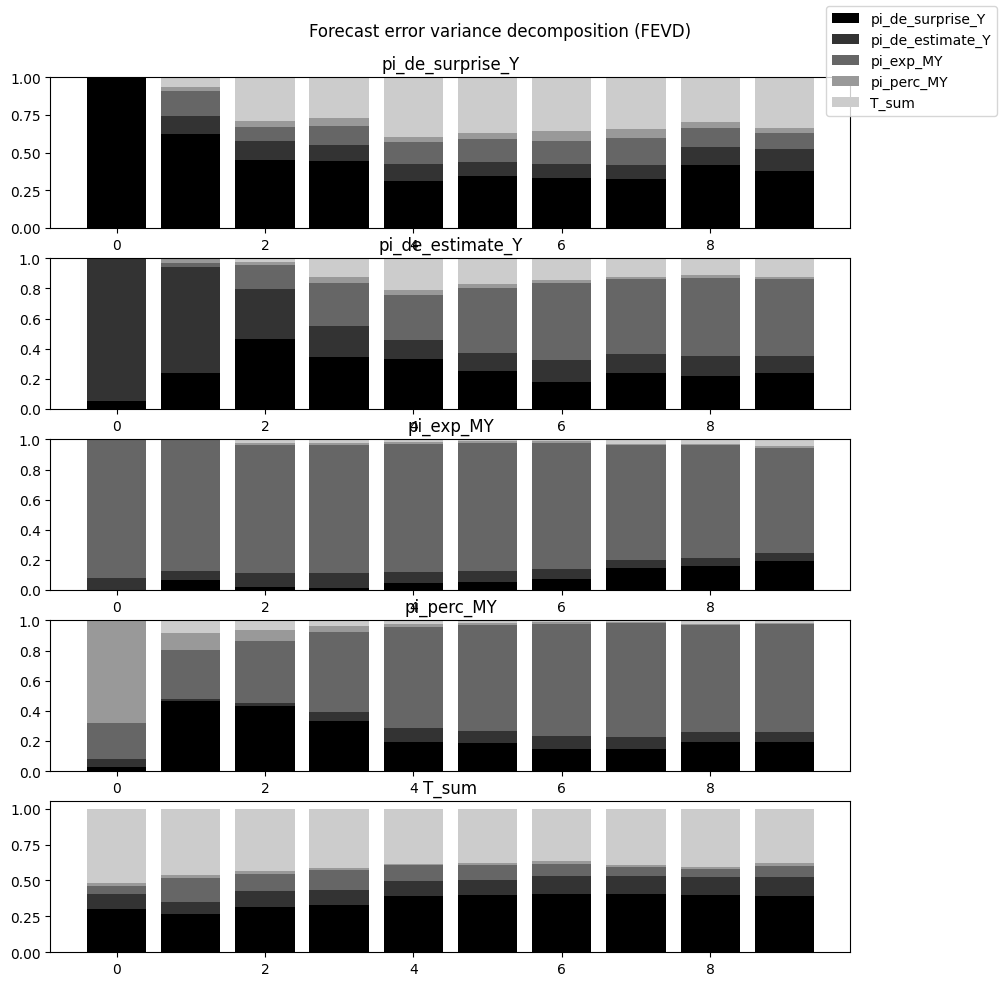

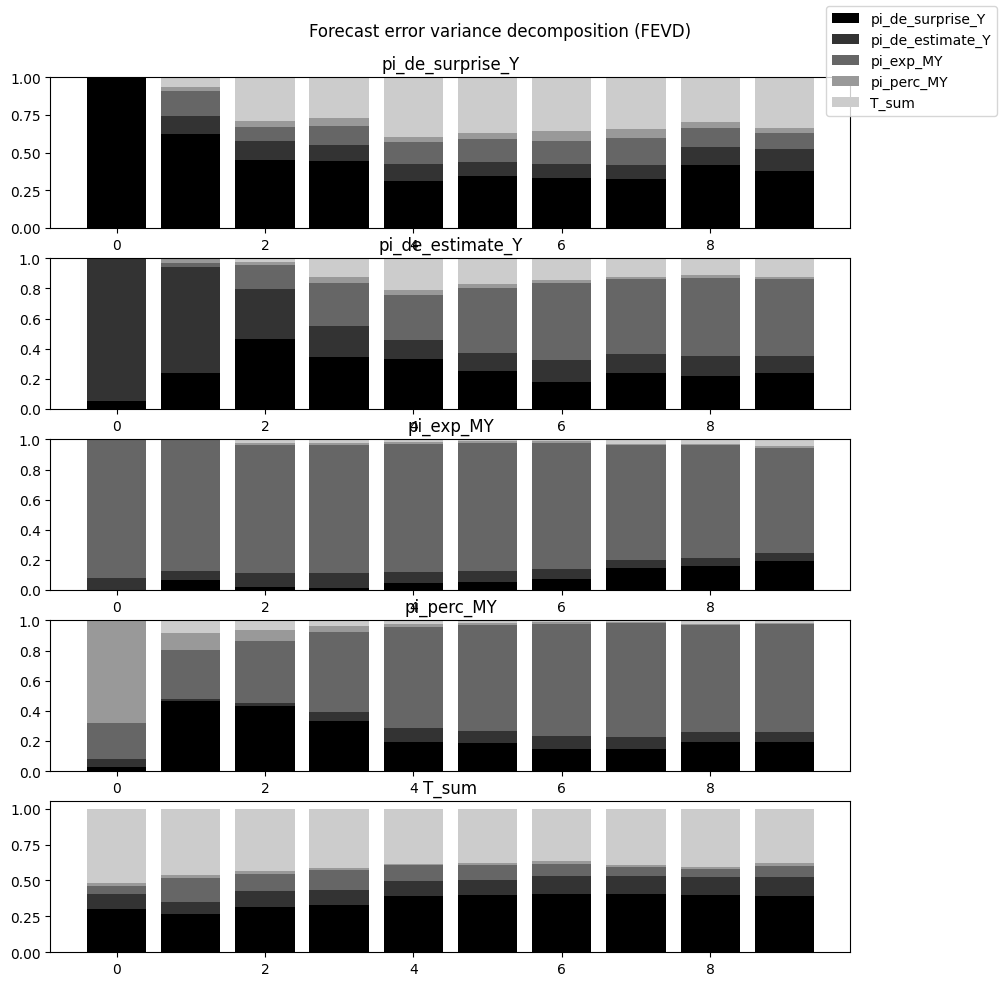

In [289]:
var.fevd().plot()

In [283]:
cols_endog, cols_exog = ['pi_perc_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 3) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
3
3 0


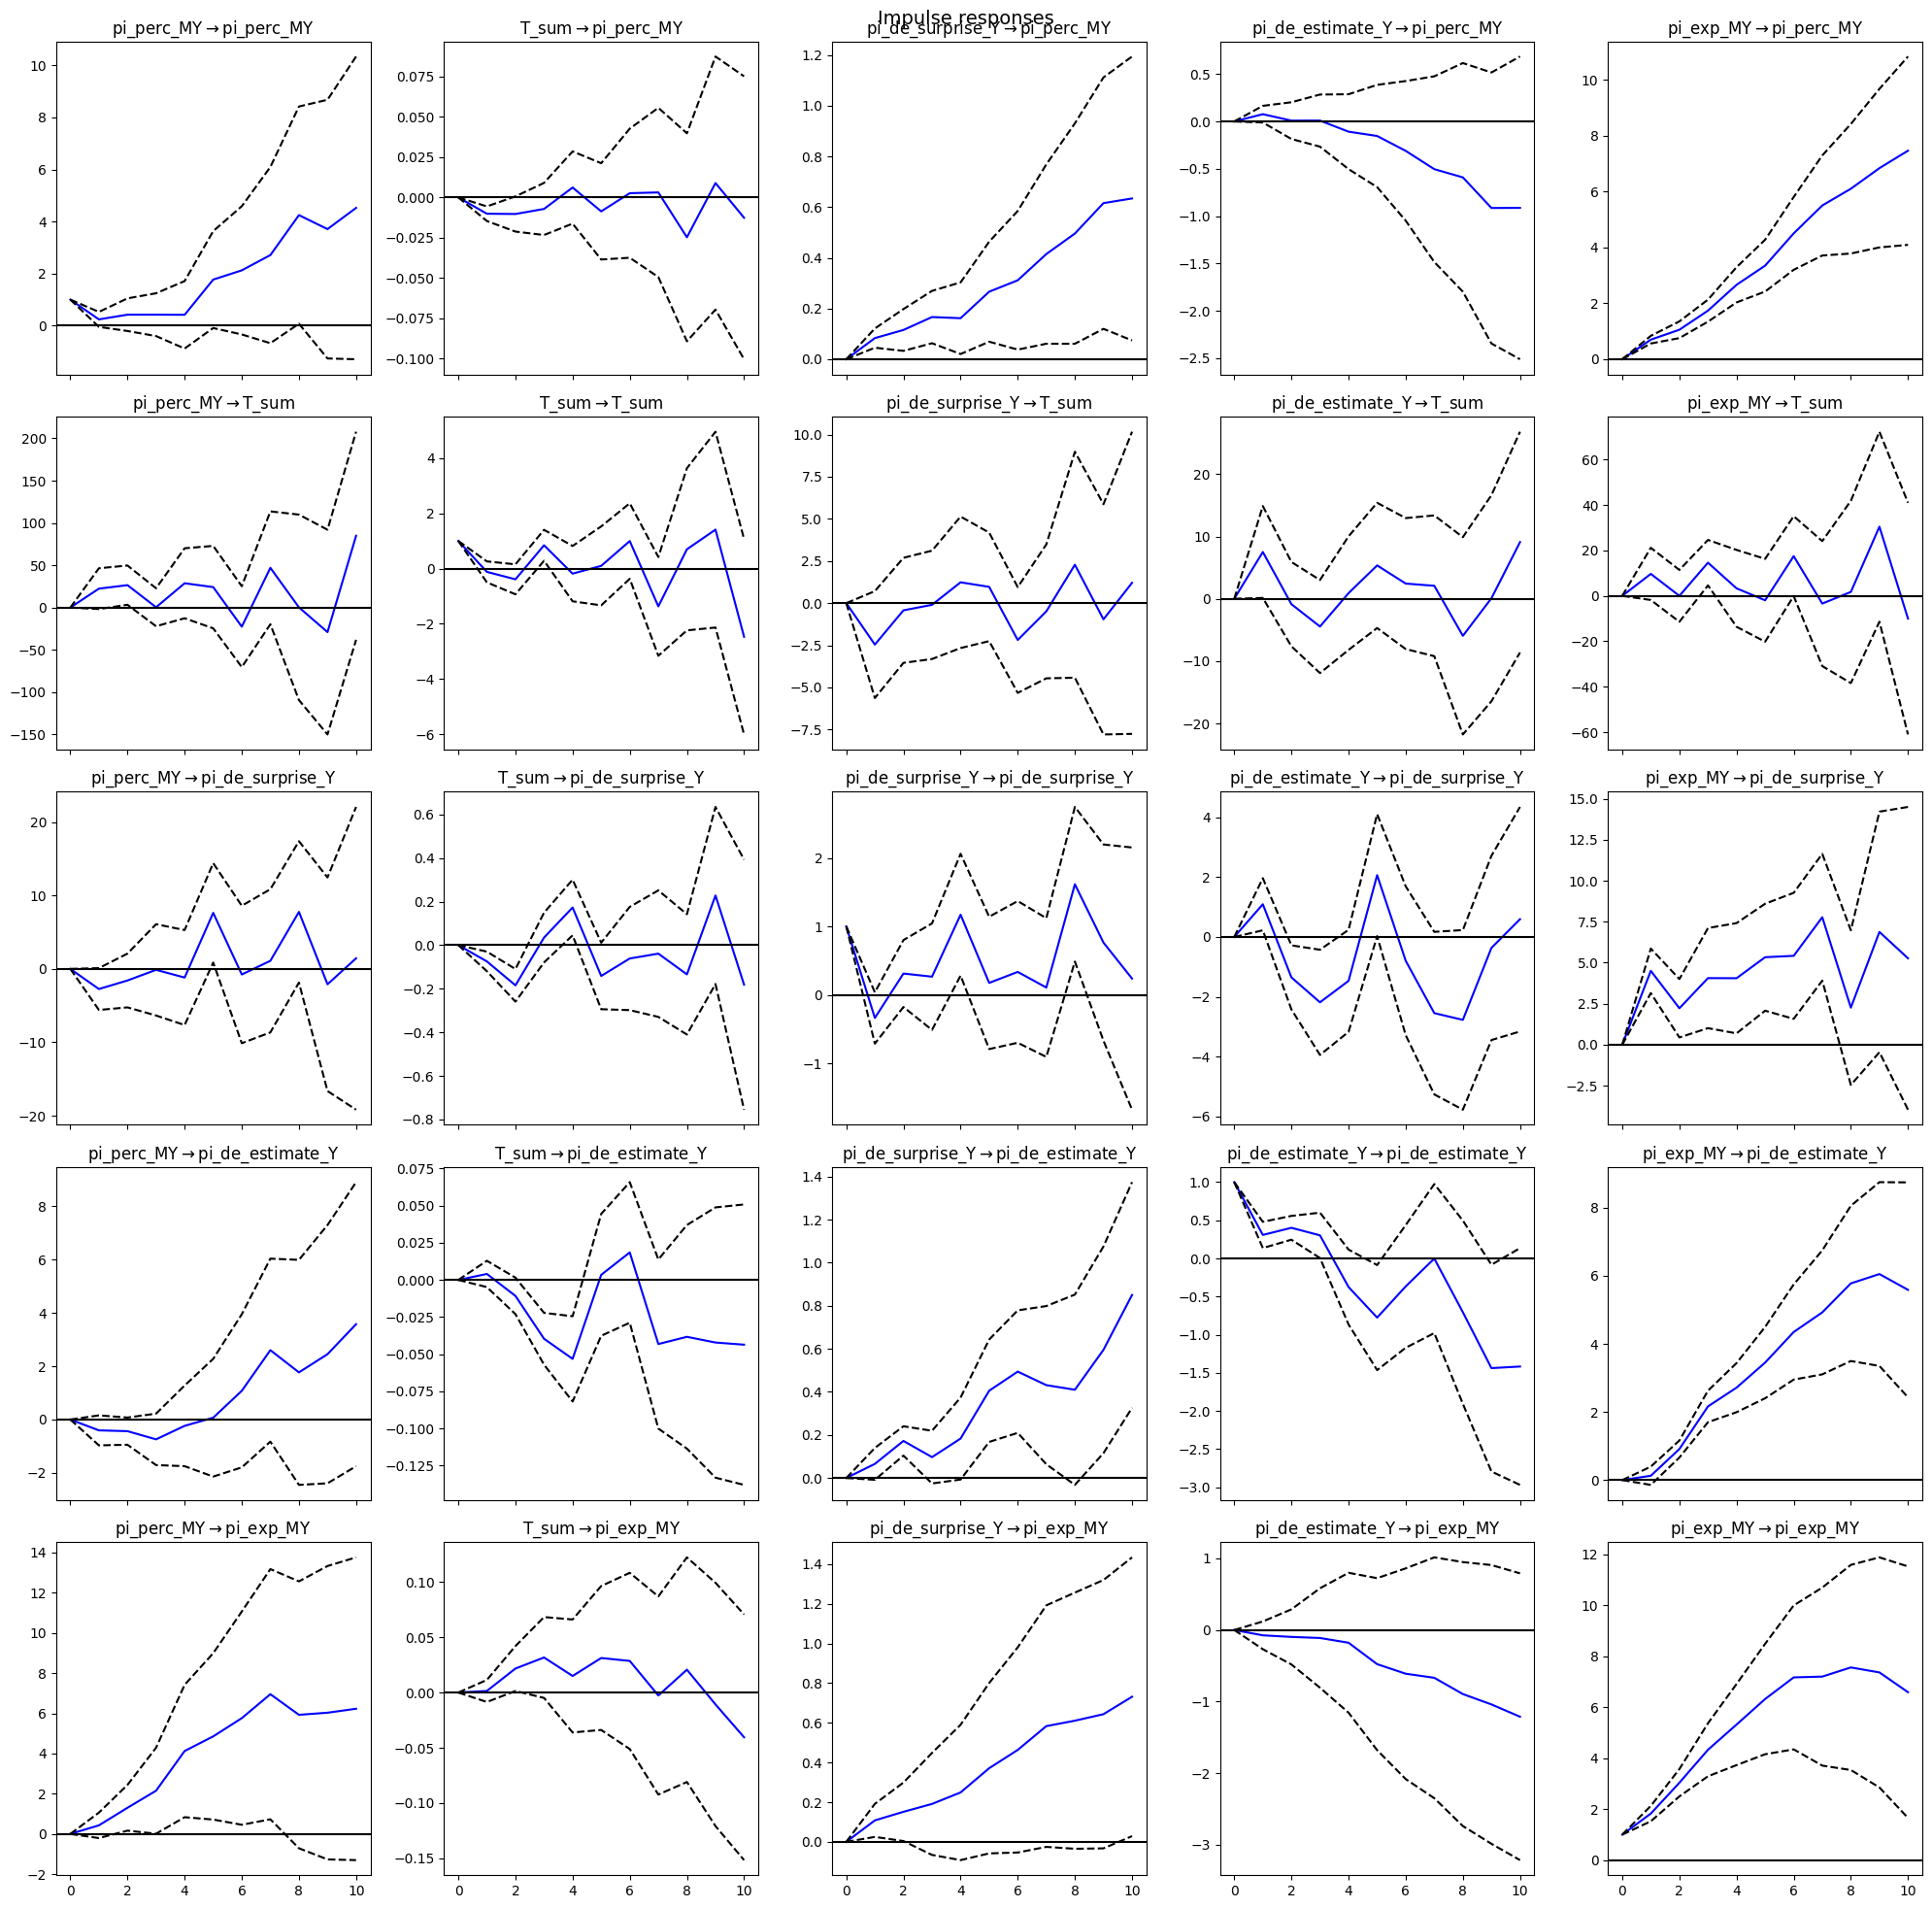

In [284]:
vecm.irf().plot(figsize=(20,20))
plt.tight_layout();

# Micro analysis

In [201]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

In [202]:
df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y

In [152]:
_ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
df['pi_perc_error'] = _

In [205]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
        'pi_de_surprise_Y': float,
        'pi_de_estimate_Y': float,
        'delta_pe_error': float,
    }
)

In [206]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [207]:
ind_cols = ['id', 'week_recorded']
sub = df[['pi_perc'] + ind_cols].copy().reset_index(drop=True).drop_duplicates()

filt = sub.groupby(ind_cols).pi_perc.last().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(list(filt[filt].index))].set_index(ind_cols).sort_index()
sub = sub.dropna()
filt.sum()

377

In [209]:
dist = df.groupby('id')[['hhinc_midpoint', 'pi_perc_error', 'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust']].last().astype(float)

dist = dist.loc[sub.index.get_level_values(0)]
dist = dist.loc[~dist.index.duplicated()]
# dist = scipy.spatial.distance.cdist(dist, dist.mean(axis=0).values[None])
dist = scipy.spatial.distance.cdist(dist, dist)

dist[np.isnan(dist)] = np.array(list([0] * np.isnan(dist).sum()))
dist = dist.mean(axis=0)

<AxesSubplot: xlabel='week_recorded', ylabel='id'>

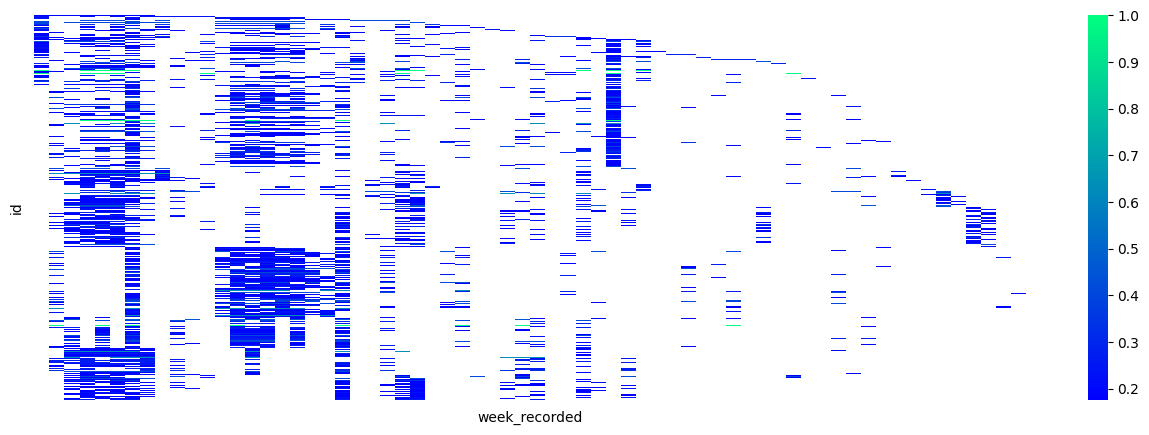

In [210]:
A = ~sub.unstack().isna()
A = (A * ((dist - dist.min()) / (dist.max() - dist.min()))[:, None]).replace({0: np.nan})
A.columns = A.columns.get_level_values(1)

fig = plt.figure(figsize=(16,5))
sns.heatmap(A, xticklabels=False, yticklabels=False, cmap='winter')

## POLS: How do news affect inflation perception on an individual level?

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [211]:
cols = ['T_sum_diff_lag', 'hhinc', 'pi_de_Y', 'is_unempl',] # 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [212]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 5), 1492)

In [161]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                pi_perc   R-squared:                        0.2580
Estimator:                   PanelOLS   R-squared (Between):              0.8040
No. Observations:                8055   R-squared (Within):               0.2580
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.7510
Time:                        15:46:16   Log-likelihood                 2.009e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      151.80
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                 F(15,6548)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             131.53
                            

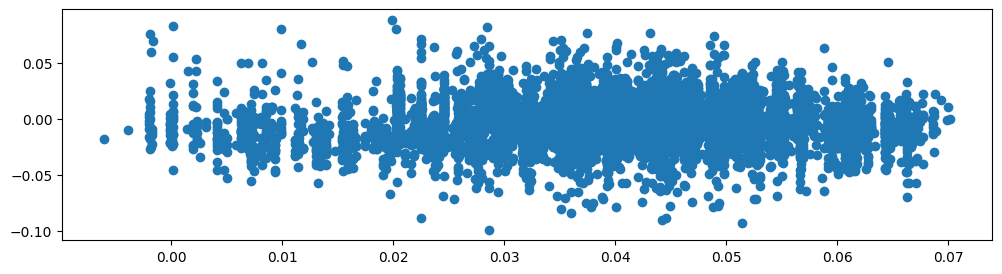

In [162]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [163]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 109.1957241778076, 'LM p-val': 1.080209178139093e-22, 'F-Stat': 27.656910147726887, 'F p-val': 7.689086948782225e-23}


In [164]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.0029516411291644


In [165]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 44.86704058303371
degrees of freedom: 15
p-Value: 8.036073195602008e-05


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [166]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y', 'debt', 'is_unempl', 'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [167]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 3
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2982, 7), 715)

In [168]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:               delta_pe   R-squared:                        0.0524
Estimator:                   PanelOLS   R-squared (Between):             -7.1849
No. Observations:                2982   R-squared (Within):               0.0524
Date:                Wed, Mar 27 2024   R-squared (Overall):             -1.2833
Time:                        15:46:32   Log-likelihood                    9175.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.6385
Entities:                         715   P-value                           0.0000
Avg Obs:                       4.1706   Distribution:                 F(22,2245)
Min Obs:                       4.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.543
                            

In [169]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 510.9521106085888, 'LM p-val': 3.674761691882483e-107, 'F-Stat': 102.52617493348329, 'F p-val': 1.247217174020557e-117}


In [170]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.1744810405531907


In [171]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 237.59000063708717
degrees of freedom: 22
p-Value: 4.3056138794273853e-38


# Exp 3

Influence of news on expectation:
$$ \pi^e_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [174]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_exp']

In [175]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((29619, 4), 4300)

In [176]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 pi_exp   R-squared:                        0.4398
Estimator:                   PanelOLS   R-squared (Between):              0.8507
No. Observations:               29619   R-squared (Within):               0.4398
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.8014
Time:                        15:46:51   Log-likelihood                 7.752e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6624.9
Entities:                        4300   P-value                           0.0000
Avg Obs:                       6.8881   Distribution:                 F(3,25316)
Min Obs:                       6.0000                                           
Max Obs:                       12.000   F-statistic (robust):             3964.8
                            

In [177]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 120.75848270961693, 'LM p-val': 5.297613746115009e-26, 'F-Stat': 40.4121543239461, 'F p-val': 4.7205822432122384e-26}


In [178]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

1.9869566194668744


In [179]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 468.9347857900488
degrees of freedom: 3
p-Value: 2.5735022448138416e-101


## Exp 4

In [217]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_error']

In [218]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 4), 1492)

In [219]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:          pi_perc_error   R-squared:                        0.3184
Estimator:                   PanelOLS   R-squared (Between):             -4.3152
No. Observations:                8055   R-squared (Within):               0.3184
Date:                Wed, Mar 27 2024   R-squared (Overall):             -0.8175
Time:                        15:52:50   Log-likelihood                 2.008e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1021.5
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                  F(3,6560)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             855.44
                            

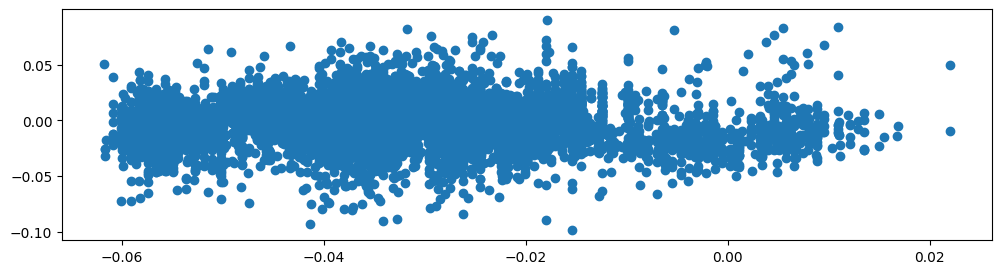

In [220]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [221]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 104.1791315219897, 'LM p-val': 1.9621389302204236e-22, 'F-Stat': 35.16392423533056, 'F p-val': 1.433350641350051e-22}


In [222]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.001561105798445


In [223]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 931.4046277496547
degrees of freedom: 3
p-Value: 1.3646763405726904e-201


## Exp 5

In [245]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe_error']

In [246]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((45794, 4), 7279)

In [247]:
sub = sub.loc[~sub.duplicated()]

In [248]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:         delta_pe_error   R-squared:                        0.8543
Estimator:                   PanelOLS   R-squared (Between):              0.9753
No. Observations:                2872   R-squared (Within):               0.8543
Date:                Wed, Mar 27 2024   R-squared (Overall):              0.9714
Time:                        15:54:51   Log-likelihood                    9918.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2359.9
Entities:                        1662   P-value                           0.0000
Avg Obs:                       1.7280   Distribution:                  F(3,1207)
Min Obs:                       1.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             2929.4
                            

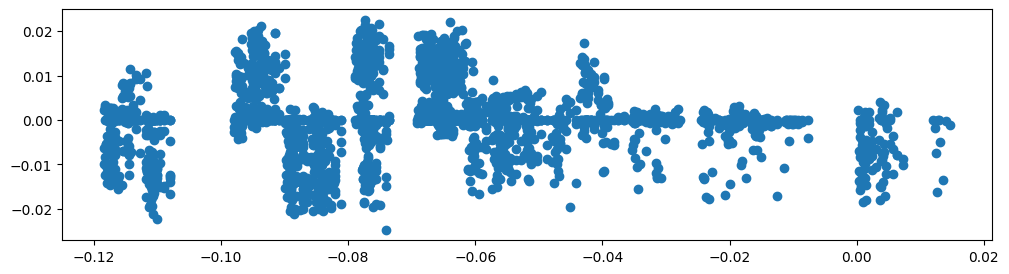

In [249]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [250]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 64.81053334521283, 'LM p-val': 5.50664050030162e-14, 'F-Stat': 22.07149557021431, 'F p-val': 3.973376952388344e-14}


In [251]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.1546787752309653


In [252]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 25.861867544949117
degrees of freedom: 3
p-Value: 1.0194101898097498e-05
